In [87]:
%pip install requests
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [88]:
import requests
import time
import os
import json
import base64
import statistics

folder_path = "extended_records"
records = os.path.join(os.getcwd(), folder_path)

all_times = {
    "LIST_OPS(service)": {"values_w_o_api": [], "avg_w_o_api": 0, "std_w_o_api": 0},
    "LIST_FDOS": {"values_w_o_api": [], "avg_w_o_api": 0, "std_w_o_api": 0},
    "GET_FDO": {"values_w_o_api": [], "avg_w_o_api": 0, "std_w_o_api": 0},
    "LIST_OPS(FDOs)": {"values_w_o_api": [], "avg_w_o_api": 0, "std_w_o_api": 0},
    "EVALUATE_LICENSE": {"values_w_api": [], "avg_w_api": 0, "std_w_api": 0, "values_w_o_api": [], "avg_w_o_api": 0, "std_w_o_api": 0},
    "FIND_ANNOTATION": {"values_w_api": [], "avg_w_api": 0, "std_w_api": 0, "values_w_o_api": [], "avg_w_o_api": 0, "std_w_o_api": 0},
    "FIND_METADATA": {"values_w_api": [], "avg_w_api": 0, "std_w_api": 0, "values_w_o_api": [], "avg_w_o_api": 0, "std_w_o_api": 0},
    "FIND_LITERATURE": {"values_w_api": [], "avg_w_api": 0, "std_w_api": 0, "values_w_o_api": [], "avg_w_o_api": 0, "std_w_o_api": 0},
    "GET_ORCID": {"values_w_api": [], "avg_w_api": 0, "std_w_api": 0, "values_w_o_api": [], "avg_w_o_api": 0, "std_w_o_api": 0},
    "GET_THUMBNAIL": {"values_w_api": [], "avg_w_api": 0, "std_w_api": 0, "values_w_o_api": [], "avg_w_o_api": 0, "std_w_o_api": 0},
    "VALIDATE_SCHEMA": {"values_w_api": [], "avg_w_api": 0, "std_w_api": 0, "values_w_o_api": [], "avg_w_o_api": 0, "std_w_o_api": 0},
    "RECOMMEND_LITERATURE": {"values_w_api": [], "avg_w_api": 0, "std_w_api": 0, "values_w_o_api": [], "avg_w_o_api": 0, "std_w_o_api": 0},
    "FIND_SOFTWARE": {"values_w_api": [], "avg_w_api": 0, "std_w_api": 0, "values_w_o_api": [], "avg_w_o_api": 0, "std_w_o_api": 0},
}

In [89]:
def execute_tpm_adapter(ops_type, payload, track=True):
    # Start timing
    start_time = time.perf_counter()
    # For a GET request
    #response = requests.get(url, params=data)

    service_ops = ["LIST_OPS(service)", "LIST_FDOS", "GET_FDO", "LIST_OPS(FDOs)"]
    # For a POST request
    url = "http://localhost:5002/doip"
    response = requests.post(url, json=payload)
    if track:
        end_time = time.perf_counter()
        elapsed_time_total = end_time - start_time
        elapsed_time_w_api = elapsed_time_total
        if ops_type not in service_ops:
            all_times[ops_type]["values_w_api"].append(elapsed_time_w_api*1000)
            try:
                all_times[ops_type]["avg_w_api"] = statistics.mean(all_times[ops_type]["values_w_api"])
                all_times[ops_type]["std_w_api"] =  statistics.stdev(all_times[ops_type]["values_w_api"])
            except statistics.StatisticsError:
                all_times[ops_type]["avg_w_api"] = all_times[ops_type]["values_w_api"][0]
                all_times[ops_type]["std_w_api"] = all_times[ops_type]["values_w_api"][0]
        
        # time without Web API response
        elapsed_time_w_o_api=elapsed_time_total - response.json()["elapsed_time"]
        all_times[ops_type]["values_w_o_api"].append(elapsed_time_w_o_api*1000)
        try:
            all_times[ops_type]["avg_w_o_api"] = statistics.mean(all_times[ops_type]["values_w_o_api"])
            all_times[ops_type]["std_w_o_api"] =  statistics.stdev(all_times[ops_type]["values_w_o_api"])
        except statistics.StatisticsError:
            all_times[ops_type]["avg_w_o_api"] = all_times[ops_type]["values_w_o_api"][0]
            all_times[ops_type]["std_w_o_api"] = all_times[ops_type]["values_w_o_api"][0]
    return response.json()["response"], response

In [90]:
#listing all operations available by the service
list_service_ops = {
    "operationId": "0.DOIP/OP.LIST_OPS",
    "targetId": "SERVICE"
}
response_message, full_response = execute_tpm_adapter("LIST_OPS(service)", list_service_ops)
print(json.dumps(response_message, indent=4))

{
    "available service operations": {
        "*FDO_Operation": {
            "arguments": "*",
            "operationID": "Object",
            "response type": "JSON object or encoded binary data",
            "targetID": "Object"
        },
        "0.DOIP/Op.GET_FDO": {
            "arguments": "None",
            "operationID": "0.DOIP/Op.GET_FDO",
            "response type": "PID record",
            "targetID": "Object"
        },
        "0.DOIP/Op.LIST_FDOs": {
            "arguments": "None",
            "operationID": "0.DOIP/Op.LIST_FDOs",
            "response type": "array of FDO PIDs",
            "targetID": "Service"
        },
        "0.DOIP/Op.LIST_Ops": {
            "arguments": "None",
            "operationID": "0.DOIP/Op.LIST_Ops",
            "response type": "map of service operation specifications or map of supported FDOPs for the target object",
            "targetID": "Service or Object"
        }
    }
}


In [91]:
all_pids = []
#listing and storing all FDOs registered in the TPM instance
list_fdos = {
    "operationId": "0.DOIP/Op.LIST_FDOs",
    "targetId": "SERVICE"
}
response_message, full_response  = execute_tpm_adapter("LIST_FDOS", list_fdos)
pids = json.dumps(response_message, indent=4)
dictionary_pids = json.loads(pids)
for pid in dictionary_pids["available FDOs"]:
    all_pids.append(pid["pid"])
print(pids)
print(len(all_pids))

{
    "available FDOs": [
        {
            "created": "2024-05-28T08:29:33.822226Z",
            "modified": "2024-05-28T08:29:33.822226Z",
            "pid": "sandboxed/84402b3f-df49-45c0-8e38-6437e3e24dc3"
        },
        {
            "created": "2024-05-28T08:29:33.970494Z",
            "modified": "2024-05-28T08:29:33.970494Z",
            "pid": "sandboxed/3b3d38fd-ed33-4afb-b95f-a0a0511e2d5f"
        },
        {
            "created": "2024-05-28T08:29:34.051955Z",
            "modified": "2024-05-28T08:29:34.051955Z",
            "pid": "sandboxed/280265c9-e027-43ea-9963-3b6c1a2b07dd"
        },
        {
            "created": "2024-05-28T08:29:36.690181Z",
            "modified": "2024-05-28T08:29:36.690181Z",
            "pid": "sandboxed/64952e5d-5f60-426b-9b22-2f97eac7c69c"
        },
        {
            "created": "2024-05-28T08:29:36.769271Z",
            "modified": "2024-05-28T08:29:36.769271Z",
            "pid": "sandboxed/a23d0e98-51d1-4b5c-aeab-be309348b

In [92]:
# Get the information record from each FDO PID
for pid in all_pids:
    get_fdo = {
    "operationId": "0.DOIP/Op.GET_FDO",
    "targetId": pid
    }
    response_message, full_response  = execute_tpm_adapter("GET_FDO", get_fdo)
    print(f"information record for {pid}", json.dumps(response_message, indent=4))

information record for sandboxed/84402b3f-df49-45c0-8e38-6437e3e24dc3 {
    "FDO record": {
        "entries": {
            "21.T11148/03f205d2f632dd312ce0": [
                {
                    "key": "21.T11148/03f205d2f632dd312ce0",
                    "value": "21.11152/f48bf4e7-3879-4216-8f64-45a060b8f658"
                }
            ],
            "21.T11148/076759916209e5d62bd5": [
                {
                    "key": "21.T11148/076759916209e5d62bd5",
                    "value": "21.T11148/2c3cafa4db3f3e1e51b3"
                }
            ],
            "21.T11148/1c699a5d1b4ad3ba4956": [
                {
                    "key": "21.T11148/1c699a5d1b4ad3ba4956",
                    "value": "21.11152/ba06424b-17c7-4e3f-9a2e-8d09cf797be3"
                }
            ],
            "21.T11148/2f314c8fe5fb6a0063a8": [
                {
                    "key": "21.T11148/2f314c8fe5fb6a0063a8",
                    "value": "https://creativecommons.org/licens

In [93]:
# Get the list of supported FDO Operations for a FDO (including other FDO Operations)

for pid in all_pids:
    list_fdo_ops = {
    "operationId": "0.DOIP/Op.LIST_OPS",
    "targetId": pid
    }
    response_message, full_response  = execute_tpm_adapter("LIST_OPS(FDOs)", list_fdo_ops)
    print(f"supported FDOps for {pid}", json.dumps(response_message, indent=4))

supported FDOps for sandboxed/84402b3f-df49-45c0-8e38-6437e3e24dc3 {
    "available FDOps": [
        {
            "name": "EVALUATE_LICENSE",
            "pid": "sandboxed/2e6218b1-eab6-42e0-9d07-41cfd48bdd44"
        },
        {
            "name": "FIND_LITERATURE",
            "pid": "sandboxed/183f2611-e67c-4382-83b1-7d582d75d79d"
        },
        {
            "name": "FIND_SOFTWARE",
            "pid": "sandboxed/ab604895-295c-4912-b985-f681c53d0abd"
        },
        {
            "name": "GET_ORCID",
            "pid": "sandboxed/ece8acdd-9fc5-4ed4-995c-20e4216cae6a"
        },
        {
            "name": "VALIDATE_SCHEMA",
            "pid": "sandboxed/6c8759f6-bc4f-4465-b024-e46c0ee772bc"
        }
    ]
}
supported FDOps for sandboxed/3b3d38fd-ed33-4afb-b95f-a0a0511e2d5f {
    "available FDOps": [
        {
            "name": "EVALUATE_LICENSE",
            "pid": "sandboxed/2e6218b1-eab6-42e0-9d07-41cfd48bdd44"
        },
        {
            "name": "FIND_LITERAT

In [94]:
# Get the list of FDO Operations for a specific FDO
for pid in all_pids:
    list_fdo_ops = {
    "operationId": "0.DOIP/Op.LIST_OPS",
    "targetId": pid
    }
    response_message, full_response  = execute_tpm_adapter("LIST_FDO_OPS", list_fdo_ops, track=False)
    
    # Execute supported FDO Operationss knowing the names to also track execution times
    for ops in response_message['available FDOps']:
        ops_id = ops["pid"]
        ops_name = ops["name"]
        # knowing the EVALUATE_LICENSE operation requires additional parameters, as described in the record
        if ops_name == "EVALUATE_LICENSE":
            fdo_operation = {
            "operationId": ops_id,
            "targetId": pid,
            "attributes": {
                "21.T11148/916ca3badfa68b06870c": "open access"
                }
            }
            ops_response_message, ops_full_response  = execute_tpm_adapter("EVALUATE_LICENSE", fdo_operation)
            print(f"result for operation {ops_name} with PID {ops_id} and FDO {pid}", json.dumps(ops_response_message, indent=4))
        # knowing the GET_THUMBNAIL returns a png image that needs to be encoded and should be saved
        elif ops_name == "GET_THUMBNAIL":
            fdo_operation = {
            "operationId": ops_id,
            "targetId": pid
            }
            ops_response_message, ops_full_response  = execute_tpm_adapter("GET_THUMBNAIL", fdo_operation)
            print(f"result for operation {ops_name} with PID {ops_id} and FDO {pid}", json.dumps(ops_response_message, indent=4))
            parts = pid.split('/')
            filename = parts[1]
            if ops_full_response.status_code == 200:
                # Decoding the Base64 strings back to binary data
                decoded_response = {key: base64.b64decode(value) for key, value in ops_full_response.json()["response"]["operation result"].items()}
                for request, data in decoded_response.items():
                    with open(f'{filename}_{request}.png', 'wb') as image_file:
                        image_file.write(data)
            else:
                print(f"Error: {ops_full_response.text}")
        elif ops_name == "FIND_ANNOTATION":
            fdo_operation = {
            "operationId": ops_id,
            "targetId": pid
            }
            ops_response_message, ops_full_response = execute_tpm_adapter("FIND_ANNOTATION", fdo_operation)
            print(f"result for operation {ops_name} with PID {ops_id} and FDO {pid}", json.dumps(ops_response_message, indent=4))
        elif ops_name == "FIND_METADATA":
            fdo_operation = {
            "operationId": ops_id,
            "targetId": pid
            }
            ops_response_message, ops_full_response = execute_tpm_adapter("FIND_METADATA", fdo_operation)
            print(f"result for operation {ops_name} with PID {ops_id} and FDO {pid}", json.dumps(ops_response_message, indent=4))
        elif ops_name == "VALIDATE_SCHEMA":
            fdo_operation = {
            "operationId": ops_id,
            "targetId": pid
            }
            ops_response_message, ops_full_response = execute_tpm_adapter("VALIDATE_SCHEMA", fdo_operation)
            print(f"result for operation {ops_name} with PID {ops_id} and FDO {pid}", json.dumps(ops_response_message, indent=4))
        elif ops_name == "GET_ORCID":
            fdo_operation = {
            "operationId": ops_id,
            "targetId": pid
            }
            ops_response_message, ops_full_response = execute_tpm_adapter("GET_ORCID", fdo_operation)
            print(f"result for operation {ops_name} with PID {ops_id} and FDO {pid}", json.dumps(ops_response_message, indent=4))
        elif ops_name == "RECOMMEND_LITERATURE":
            ops7 = {
            "operationId": ops_id,
            "targetId": pid
            }
            ops_response_message, ops_full_response = execute_tpm_adapter("RECOMMEND_LITERATURE", ops7)
            print(f"result for operation {ops_name} with PID {ops_id} and FDO {pid}", json.dumps(ops_response_message, indent=4))
        elif ops_name == "FIND_SOFTWARE":
            ops8 = {
            "operationId": ops_id,
            "targetId": pid
            }
            ops_response_message, ops_full_response = execute_tpm_adapter("FIND_SOFTWARE", ops8)
            print(f"result for operation {ops_name} with PID {ops_id} and FDO {pid}", json.dumps(ops_response_message, indent=4))
        elif ops_name == "FIND_LITERATURE":
            ops9 = {
            "operationId": ops_id,
            "targetId": pid
            }
            ops_response_message, ops_full_response = execute_tpm_adapter("FIND_LITERATURE", ops9)
            print(f"result for operation {ops_name} with PID {ops_id} and FDO {pid}", json.dumps(ops_response_message, indent=4))
        else:
            pass

result for operation EVALUATE_LICENSE with PID sandboxed/2e6218b1-eab6-42e0-9d07-41cfd48bdd44 and FDO sandboxed/84402b3f-df49-45c0-8e38-6437e3e24dc3 {
    "operation result": {
        "request 1.1": {
            "result": true
        }
    }
}
result for operation FIND_LITERATURE with PID sandboxed/183f2611-e67c-4382-83b1-7d582d75d79d and FDO sandboxed/84402b3f-df49-45c0-8e38-6437e3e24dc3 {
    "operation result": {
        "request 1.1": [
            {
                "entries": {
                    "21.T11148/01bdb13fcd6d26156cf2": [
                        {
                            "key": "21.T11148/01bdb13fcd6d26156cf2",
                            "name": "semanticScholarID",
                            "value": "031b498ff07181df22b7e1ec5c784451d213a35b"
                        }
                    ],
                    "21.T11148/076759916209e5d62bd5": [
                        {
                            "key": "21.T11148/076759916209e5d62bd5",
                     

In [95]:
# overview of execution times
print(json.dumps(all_times, indent=4))

{
    "LIST_OPS(service)": {
        "values_w_o_api": [
            5.6706310006120475
        ],
        "avg_w_o_api": 5.6706310006120475,
        "std_w_o_api": 5.6706310006120475
    },
    "LIST_FDOS": {
        "values_w_o_api": [
            15.479620000405703
        ],
        "avg_w_o_api": 15.479620000405703,
        "std_w_o_api": 15.479620000405703
    },
    "GET_FDO": {
        "values_w_o_api": [
            23.361156998362276,
            16.968914000244695,
            10.735197000030894,
            9.846256001765141,
            8.992418999696383,
            9.26042599894572,
            9.905613998853369,
            9.189611000692821,
            9.727943999678246,
            10.10635300008289,
            10.363228000642266,
            9.564553998643532,
            10.695261000364553,
            10.422073000881937,
            11.775212000429747,
            10.974338001688011,
            10.013479999543051,
            10.417471999971895,
            9.18

/var/folders/kw/rfkc7d0959z0b9z5yr3r7m2r0000gn/T/ipykernel_831/1472880480.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


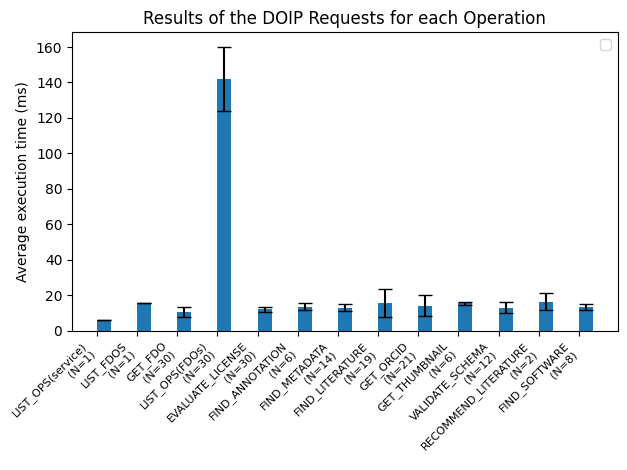

In [96]:
import matplotlib.pyplot as plt
import numpy as np

data = all_times

# Calculate averages and standard deviations
for key, value in data.items():
    if value['values_w_o_api']:
        value['avg_w_o_api'] = np.mean(value['values_w_o_api'])
        value['std_w_o_api'] = np.std(value['values_w_o_api'])

# Prepare data for plotting
ops_names = list(data.keys())
avg_w_o_api = [data[op]['avg_w_o_api'] for op in ops_names]
std_w_o_api = [data[op]['std_w_o_api'] for op in ops_names]

# Add number of values to the tick labels
ops_names_with_counts = [
    f"{op}\n(N={len(data[op]['values_w_o_api'])})" for op in ops_names
]

# Plotting
x = np.arange(len(ops_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects2 = ax.bar(x + width/2, avg_w_o_api, width, yerr=std_w_o_api, capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average execution time (ms)')
ax.set_xticks(x)
ax.set_title("Results of the DOIP Requests for each Operation")
ax.set_xticklabels(ops_names_with_counts, rotation=45, ha='right', fontsize=8)
ax.legend()

fig.tight_layout()

plt.show()
